In [1]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, models
from torchvision.models import DenseNet121_Weights

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image
import time
from tqdm import tqdm
import glob


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha: float = 1.0, gamma: float = 2.0, reduction: str = 'mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [4]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing: float = 0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
        log_prob = F.log_softmax(input, dim=-1)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        return (-weight * log_prob).sum(dim=-1).mean()


In [5]:
class MixUpAugmentation:
    def __init__(self, alpha: float = 1.0):
        self.alpha = alpha

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, float]:
        lam = np.random.beta(self.alpha, self.alpha) if self.alpha > 0 else 1
        index = torch.randperm(x.size(0)).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        return mixed_x, y, y[index], lam


In [6]:
class BreakHisDataset(Dataset):
    def __init__(self, image_paths: List[str], labels: List[int], transform: Optional[transforms.Compose] = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception:
            image = Image.new('RGB', (299, 299), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


In [7]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes: int = 2, dropout_rate: float = 0.5):
        super().__init__()
        self.backbone = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
        num_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(num_features, 512),
            nn.ReLU(True),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )
        self._init_classifier_weights()

    def _init_classifier_weights(self):
        for m in self.backbone.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.backbone(x)

    def freeze_backbone(self):
        for name, param in self.backbone.named_parameters():
            if 'classifier' not in name:
                param.requires_grad = False


In [8]:
class WarmupScheduler:
    def __init__(self, optimizer, warmup_epochs: int, base_lr: float):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.base_lr = base_lr
        self.current_epoch = 0

    def step(self):
        if self.current_epoch < self.warmup_epochs:
            lr = self.base_lr * (self.current_epoch + 1) / self.warmup_epochs
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        self.current_epoch += 1

In [9]:
class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 0.001, mode: str = 'min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score: float):
        if self.best_score is None:
            self.best_score = val_score
        elif self.mode == 'min':
            if val_score < self.best_score - self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        else:
            if val_score > self.best_score + self.min_delta:
                self.best_score = val_score
                self.counter = 0
            else:
                self.counter += 1
        if self.counter >= self.patience:
            self.early_stop = True

In [10]:
class MetricsCalculator:
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> Dict[str, float]:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        f1 = f1_score(y_true, y_pred)
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'auc_roc': auc_roc,
            'confusion_matrix': cm
        }

    @staticmethod
    def plot_confusion_matrix(cm: np.ndarray, title: str = "Confusion Matrix"):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Benign', 'Malignant'],
                    yticklabels=['Benign', 'Malignant'])
        plt.title(title)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()


In [11]:
class BreakHisTrainer:
    """Main trainer class for BreakHis dataset."""

    def __init__(self, data_dir: str, batch_size: int = 32,
                 num_workers: int = 4, device: str = 'cuda',
                 use_mixup: bool = True, use_focal_loss: bool = True):
        self.data_dir = Path(data_dir)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.use_mixup = use_mixup
        self.use_focal_loss = use_focal_loss

        print(f"Using device: {self.device}")

        # Results storage
        self.results = {}

        # Initialize Mixup if enabled
        if self.use_mixup:
            self.mixup = MixUpAugmentation(alpha=1.0)

        # Enhanced data transforms
        self.train_transforms = transforms.Compose([
            transforms.Resize((342, 342)),
            transforms.CenterCrop(299),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05),
                                  scale=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.val_transforms = transforms.Compose([
            transforms.Resize((342, 342)),
            transforms.CenterCrop(299),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

    def find_dataset_structure(self) -> str:
        """Find the correct dataset structure."""
        print(f"Searching for dataset in: {self.data_dir}")

        # Check if the directory exists
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Dataset directory does not exist: {self.data_dir}")

        # List all files and directories
        print("Directory contents:")
        for item in self.data_dir.iterdir():
            print(f"  {item}")

        # Try different possible patterns
        patterns = [
            "**/*.png",
            "**/*.PNG",
            "**/*.jpg",
            "**/*.JPG",
            "**/*.jpeg",
            "**/*.JPEG"
        ]

        for pattern in patterns:
            files = list(self.data_dir.glob(pattern))
            if files:
                print(f"Found {len(files)} files with pattern: {pattern}")
                return pattern

        raise FileNotFoundError(f"No image files found in {self.data_dir}")

    def parse_dataset(self) -> Dict[str, List]:
        """Parse BreakHis dataset structure with improved path handling."""
        print("🔍 Parsing BreakHis dataset...")

        # Find the correct file pattern
        pattern = self.find_dataset_structure()
        image_paths = list(self.data_dir.glob(pattern))

        print(f"📁 Found {len(image_paths)} image files")

        data_info = {
            'image_paths': [],
            'labels': [],
            'magnifications': [],
            'patient_ids': []
        }

        benign_count = 0
        malignant_count = 0

        for img_path in image_paths:
            try:
                img_path_str = str(img_path).lower()
                filename = img_path.name.lower()

                # First, check for malignant indicators
                if 'sob_m_' in filename or 'malignant' in img_path_str or '_m_' in filename:
                    label = 1
                    malignant_count += 1
                elif 'sob_b_' in filename or 'benign' in img_path_str or '_b_' in filename:
                    label = 0
                    benign_count += 1
                else:
                    # If uncertain, skip
                    continue

                # Extract magnification
                magnification = 'Unknown'
                for mag in ['40X', '100X', '200X', '400X']:
                    if mag.lower() in filename or f"-{mag[:-1]}-" in filename:
                        magnification = mag
                        break

                # Extract patient ID
                if 'sob_' in filename:
                    parts = filename.split('-')
                    if len(parts) >= 3:
                        patient_id = '-'.join(parts[:3])
                    else:
                        patient_id = filename.split('.')[0]
                else:
                    patient_id = filename.split('.')[0]

                data_info['image_paths'].append(str(img_path))
                data_info['labels'].append(label)
                data_info['magnifications'].append(magnification)
                data_info['patient_ids'].append(patient_id)

            except Exception as e:
                print(f"⚠️ Error processing {img_path}: {e}")
                continue

        print(f"✅ Successfully parsed {len(data_info['image_paths'])} images")
        print(f"📊 Benign: {benign_count}")
        print(f"📊 Malignant: {malignant_count}")
        print(f"🔍 Magnifications found: {set(data_info['magnifications'])}")
        print(f"👥 Unique patients: {len(set(data_info['patient_ids']))}")

        if len(data_info['image_paths']) == 0:
            raise ValueError("No valid images found! Check dataset structure and naming convention.")

        return data_info


    def create_patient_splits(self, data_info: Dict, test_size: float = 0.2,
                            val_size: float = 0.2) -> Dict[str, Dict]:
        """Create patient-level train/val/test splits."""
        print("📊 Creating patient-level splits...")

        df = pd.DataFrame(data_info)

        # Handle cases where patient IDs might not be unique across labels
        patient_labels = df.groupby('patient_ids')['labels'].agg(lambda x: x.mode()[0]).reset_index()

        # Check if we have both classes
        unique_labels = patient_labels['labels'].unique()
        if len(unique_labels) < 2:
            print("⚠️ Warning: Only one class found. Using random splits.")
            # Random splits without stratification
            all_patients = patient_labels['patient_ids'].tolist()
            train_val_patients, test_patients = train_test_split(
                all_patients, test_size=test_size, random_state=42
            )
            train_patients, val_patients = train_test_split(
                train_val_patients, test_size=val_size/(1-test_size), random_state=42
            )
        else:
            # Stratified splits
            train_val_patients, test_patients = train_test_split(
                patient_labels['patient_ids'].tolist(),
                test_size=test_size,
                stratify=patient_labels['labels'].tolist(),
                random_state=42
            )

            train_val_labels = patient_labels[
                patient_labels['patient_ids'].isin(train_val_patients)
            ]['labels'].tolist()

            train_patients, val_patients = train_test_split(
                train_val_patients,
                test_size=val_size / (1 - test_size),
                stratify=train_val_labels,
                random_state=42
            )

        # Create splits for each magnification
        magnifications = list(set(data_info['magnifications'])) + ['All']
        splits = {}

        for mag in magnifications:
            if mag == 'All':
                mag_mask = pd.Series([True] * len(df))
            else:
                mag_mask = df['magnifications'] == mag

            mag_df = df[mag_mask]

            if len(mag_df) == 0:
                continue

            train_mask = mag_df['patient_ids'].isin(train_patients)
            val_mask = mag_df['patient_ids'].isin(val_patients)
            test_mask = mag_df['patient_ids'].isin(test_patients)

            splits[mag] = {
                'train': {
                    'image_paths': mag_df[train_mask]['image_paths'].tolist(),
                    'labels': mag_df[train_mask]['labels'].tolist()
                },
                'val': {
                    'image_paths': mag_df[val_mask]['image_paths'].tolist(),
                    'labels': mag_df[val_mask]['labels'].tolist()
                },
                'test': {
                    'image_paths': mag_df[test_mask]['image_paths'].tolist(),
                    'labels': mag_df[test_mask]['labels'].tolist()
                }
            }

            print(f"\n{mag} - Train: {len(splits[mag]['train']['labels'])}, "
                  f"Val: {len(splits[mag]['val']['labels'])}, "
                  f"Test: {len(splits[mag]['test']['labels'])}")

        return splits

    def create_data_loaders(self, splits: Dict, magnification: str) -> Dict[str, DataLoader]:
        """Create data loaders for a specific magnification."""

        if magnification not in splits:
            raise ValueError(f"Magnification {magnification} not found in splits")

        split_data = splits[magnification]

        # Create datasets
        train_dataset = BreakHisDataset(
            split_data['train']['image_paths'],
            split_data['train']['labels'],
            self.train_transforms
        )

        val_dataset = BreakHisDataset(
            split_data['val']['image_paths'],
            split_data['val']['labels'],
            self.val_transforms
        )

        test_dataset = BreakHisDataset(
            split_data['test']['image_paths'],
            split_data['test']['labels'],
            self.val_transforms
        )

        # Handle class imbalance with weighted sampling if we have both classes
        train_labels = split_data['train']['labels']
        unique_labels = list(set(train_labels))

        if len(unique_labels) > 1:
            class_weights = compute_class_weight(
                'balanced',
                classes=np.array(unique_labels),
                y=train_labels
            )

            # Create a mapping from label to weight
            label_to_weight = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
            sample_weights = [label_to_weight[label] for label in train_labels]

            sampler = WeightedRandomSampler(
                weights=sample_weights,
                num_samples=len(sample_weights),
                replacement=True
            )
        else:
            sampler = None

        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            sampler=sampler,
            shuffle=(sampler is None),
            num_workers=self.num_workers,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        test_loader = DataLoader(
            test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True
        )

        return {
            'train': train_loader,
            'val': val_loader,
            'test': test_loader
        }

    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        """Mixup loss calculation."""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    def train_epoch(self, model: nn.Module, train_loader: DataLoader,
                   criterion: nn.Module, optimizer: torch.optim.Optimizer) -> float:
        """Train for one epoch with optional Mixup."""
        model.train()
        total_loss = 0.0
        num_batches = 0

        progress_bar = tqdm(train_loader, desc="Training")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(self.device), labels.to(self.device)

            optimizer.zero_grad()

            if self.use_mixup and np.random.rand() > 0.5:
                mixed_images, y_a, y_b, lam = self.mixup(images, labels)
                outputs = model(mixed_images)
                loss = self.mixup_criterion(criterion, outputs, y_a, y_b, lam)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

            # Update progress bar
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})

        return total_loss / num_batches

    def validate_epoch(self, model: nn.Module, val_loader: DataLoader,
                      criterion: nn.Module) -> Tuple[float, float]:
        """Validate for one epoch."""
        model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

        avg_loss = total_loss / len(val_loader)

        # Calculate AUC only if we have both classes
        if len(set(all_labels)) > 1:
            auc_roc = roc_auc_score(all_labels, all_probs)
        else:
            auc_roc = 0.0

        return avg_loss, auc_roc

    def test_model(self, model: nn.Module, test_loader: DataLoader,
                   use_tta: bool = True) -> Dict[str, float]:
        """Test the model with optional Test Time Augmentation."""
        model.eval()
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device)

                if use_tta:
                    # Simple TTA: original + horizontal flip
                    outputs1 = model(images)
                    outputs2 = model(torch.flip(images, dims=[3]))
                    outputs = (outputs1 + outputs2) / 2
                else:
                    outputs = model(images)

                probs = F.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy() if probs.shape[1] > 1 else probs[:, 0].cpu().numpy())

        return MetricsCalculator.calculate_metrics(
            np.array(all_labels),
            np.array(all_preds),
            np.array(all_probs)
        )

    def train_magnification(self, splits: Dict, magnification: str,
                          epochs: int = 100) -> Dict[str, float]:
        """Train model for a specific magnification."""

        print(f"\n{'='*60}")
        print(f"🔬 Training on {magnification} magnification")
        print(f"🧬 Using Mixup: {self.use_mixup}, Focal Loss: {self.use_focal_loss}")
        print(f"{'='*60}")

        # Create data loaders
        try:
            data_loaders = self.create_data_loaders(splits, magnification)
        except ValueError as e:
            print(f"❌ Error creating data loaders: {e}")
            return {}

        # Check if we have enough data
        if len(data_loaders['train']) == 0:
            print(f"⚠️ No training data for {magnification}")
            return {}

        # Initialize model
        model = TumorClassifier(num_classes=2, dropout_rate=0.3)
        model.to(self.device)

        # Loss function
        if self.use_focal_loss:
            criterion = FocalLoss(alpha=1.0, gamma=2.0)
        else:
            criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

        # Training setup
        model.freeze_backbone()

        base_lr = 0.001
        optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=base_lr, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5,
                                    patience=10, verbose=True)
        early_stopping = EarlyStopping(patience=15, mode='max')

        best_auc = 0.0
        best_model_state = None

        # Training loop
        for epoch in range(epochs):
            train_loss = self.train_epoch(model, data_loaders['train'],
                                        criterion, optimizer)

            val_loss, val_auc = self.validate_epoch(model, data_loaders['val'],
                                                  criterion)

            scheduler.step(val_auc)
            early_stopping(val_auc)

            print(f"Epoch {epoch+1:3d}: Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

            if val_auc > best_auc:
                best_auc = val_auc
                best_model_state = model.state_dict().copy()

            if early_stopping.early_stop:
                print(f"⏹️ Early stopping at epoch {epoch+1}")
                break

        # Load best model and test
        if best_model_state is not None:
            model.load_state_dict(best_model_state)

        test_metrics = self.test_model(model, data_loaders['test'], use_tta=True)

        print(f"\n🎯 Best validation AUC: {best_auc:.4f}")
        print(f"📊Test Metrics for {magnification} magnification:")
        for metric, value in test_metrics.items():
            if metric != 'confusion_matrix':
                print(f"  {metric.capitalize()}: {value:.4f}")

        # Plot confusion matrix
        MetricsCalculator.plot_confusion_matrix(test_metrics['confusion_matrix'],
                                                title=f"{magnification} Confusion Matrix")

        # Store result
        self.results[magnification] = test_metrics
        return test_metrics



In [12]:
def run_all_experiments(self, data_dir):
    data_info = self.parse_dataset()
    splits = self.create_patient_splits(data_info)
    results = {}

    for mag in ['40X', '100X', '200X', '400X', 'All']:
        try:
            metrics = self.train_magnification(splits, magnification=mag, epochs=50)
            if metrics:
                results[mag] = metrics
        except Exception as e:
            print(f"⚠️ Error with {mag}: {e}")
            continue

    df = pd.DataFrame([{'Magnification': mag, **metrics} for mag, metrics in results.items()]) if results else pd.DataFrame()
    self.results = results
    return df

BreakHisTrainer.run_all_experiments = run_all_experiments


In [13]:
def main():
    """Main function to run the experiments."""
    import kagglehub

    # Download dataset
    path = kagglehub.dataset_download("ambarish/breakhis")
    print("Path to dataset files:", path)

    # ✅ Corrected subdirectory path
    DATA_DIR = os.path.join(path, "BreaKHis_v1", "BreaKHis_v1", "histology_slides", "breast")

    BATCH_SIZE = 32
    NUM_WORKERS = 4
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    print(f"Using device: {DEVICE}")
    print("Using Inception-v3 backbone")

    # Initialize trainer
    trainer = BreakHisTrainer(
        data_dir=DATA_DIR,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        device=DEVICE
    )

    # Run all experiments
    results_df = trainer.run_all_experiments(DATA_DIR)

    # Save results
    if not results_df.empty:
        results_df.to_csv('breakhis_inception_v3_results.csv', index=False)
        print("\n✅ Results saved to 'breakhis_inception_v3_results.csv'")

        # Summary
        print("\n" + "="*80)
        print("📈 EXPERIMENT SUMMARY - Inception-v3")
        print("="*80)
        print(f"Average Accuracy: {results_df['accuracy'].mean():.4f}")
        print(f"Average AUC-ROC: {results_df['auc_roc'].mean():.4f}")
        print(f"Best magnification: {results_df.loc[results_df['accuracy'].idxmax(), 'Magnification']}")
    else:
        print("❌ No results were generated.")

    return results_df


Path to dataset files: /kaggle/input/breakhis
Using device: cuda
Using Inception-v3 backbone
Using device: cuda
🔍 Parsing BreakHis dataset...
Searching for dataset in: /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast
Directory contents:
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant
Found 7909 files with pattern: **/*.png
📁 Found 7909 image files
✅ Successfully parsed 7909 images
📊 Benign: 2480
📊 Malignant: 5429
🔍 Magnifications found: {'40X', '100X', '200X', '400X'}
👥 Unique patients: 82
📊 Creating patient-level splits...

40X - Train: 1172, Val: 382, Test: 441

100X - Train: 1201, Val: 403, Test: 477

200X - Train: 1188, Val: 382, Test: 443

400X - Train: 1059, Val: 367, Test: 39

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 136MB/s]
Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch   1: Train Loss: 0.1430, Val Loss: 0.1554, Val AUC: 0.8057


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch   2: Train Loss: 0.1302, Val Loss: 0.1464, Val AUC: 0.8169


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch   3: Train Loss: 0.1359, Val Loss: 0.1506, Val AUC: 0.8153


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   4: Train Loss: 0.1265, Val Loss: 0.1559, Val AUC: 0.8095


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch   5: Train Loss: 0.1196, Val Loss: 0.1596, Val AUC: 0.7827


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch   6: Train Loss: 0.1092, Val Loss: 0.1457, Val AUC: 0.8272


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   7: Train Loss: 0.1247, Val Loss: 0.1471, Val AUC: 0.8135


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch   8: Train Loss: 0.1121, Val Loss: 0.1242, Val AUC: 0.8342


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch   9: Train Loss: 0.1148, Val Loss: 0.1352, Val AUC: 0.8242


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch  10: Train Loss: 0.1160, Val Loss: 0.1597, Val AUC: 0.8144


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  11: Train Loss: 0.1097, Val Loss: 0.1442, Val AUC: 0.7930


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  12: Train Loss: 0.1151, Val Loss: 0.1499, Val AUC: 0.8858


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  13: Train Loss: 0.1100, Val Loss: 0.1219, Val AUC: 0.8989


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.73it/s]


Epoch  14: Train Loss: 0.1086, Val Loss: 0.1282, Val AUC: 0.8671


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch  15: Train Loss: 0.1158, Val Loss: 0.1308, Val AUC: 0.8640


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  16: Train Loss: 0.1065, Val Loss: 0.1198, Val AUC: 0.8553


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch  17: Train Loss: 0.1063, Val Loss: 0.1496, Val AUC: 0.7415


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  18: Train Loss: 0.1001, Val Loss: 0.1529, Val AUC: 0.8158


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  19: Train Loss: 0.1054, Val Loss: 0.1590, Val AUC: 0.8122


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.88it/s]


Epoch  20: Train Loss: 0.1116, Val Loss: 0.1878, Val AUC: 0.7859


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch  21: Train Loss: 0.1034, Val Loss: 0.1308, Val AUC: 0.8657


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch  22: Train Loss: 0.1049, Val Loss: 0.1352, Val AUC: 0.7894


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]


Epoch  23: Train Loss: 0.1125, Val Loss: 0.1096, Val AUC: 0.8764


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch  24: Train Loss: 0.1053, Val Loss: 0.1385, Val AUC: 0.7661


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch  25: Train Loss: 0.0984, Val Loss: 0.1257, Val AUC: 0.8322


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  26: Train Loss: 0.1062, Val Loss: 0.1397, Val AUC: 0.8074


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.83it/s]


Epoch  27: Train Loss: 0.1054, Val Loss: 0.1448, Val AUC: 0.8207


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.97it/s]


Epoch  28: Train Loss: 0.1129, Val Loss: 0.1101, Val AUC: 0.8543
⏹️ Early stopping at epoch 28


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.69it/s]



🎯 Best validation AUC: 0.8989
📊Test Metrics for 40X magnification:
  Accuracy: 0.8390
  Precision: 0.9017
  Recall: 0.8147
  Specificity: 0.8736
  F1: 0.8560
  Auc_roc: 0.9004


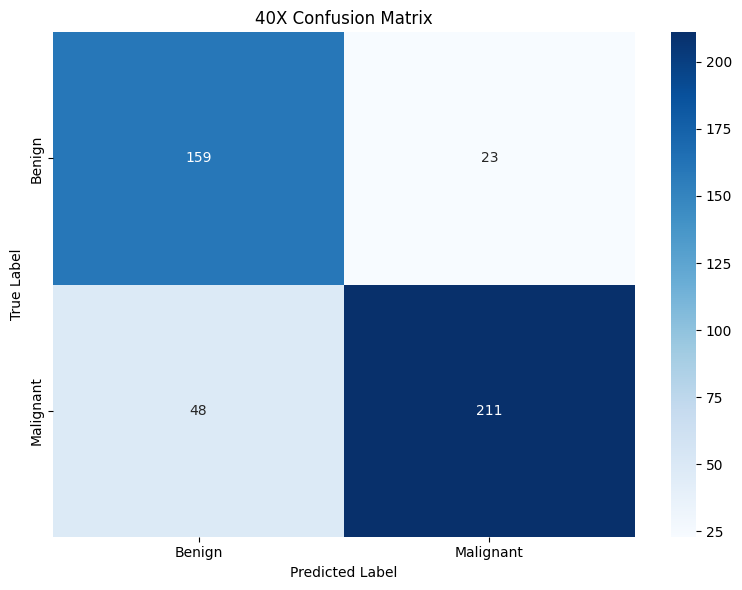


🔬 Training on 100X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.83it/s]


Epoch   1: Train Loss: 0.1480, Val Loss: 0.1261, Val AUC: 0.8304


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   2: Train Loss: 0.1342, Val Loss: 0.1028, Val AUC: 0.8969


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch   3: Train Loss: 0.1228, Val Loss: 0.1547, Val AUC: 0.8277


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch   4: Train Loss: 0.1203, Val Loss: 0.1634, Val AUC: 0.8441


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   5: Train Loss: 0.1314, Val Loss: 0.1287, Val AUC: 0.8561


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.12it/s]


Epoch   6: Train Loss: 0.1147, Val Loss: 0.1550, Val AUC: 0.8216


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.16it/s]


Epoch   7: Train Loss: 0.1234, Val Loss: 0.1261, Val AUC: 0.8458


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.84it/s]


Epoch   8: Train Loss: 0.1138, Val Loss: 0.1195, Val AUC: 0.8895


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.14it/s]


Epoch   9: Train Loss: 0.1247, Val Loss: 0.1347, Val AUC: 0.8929


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch  10: Train Loss: 0.1208, Val Loss: 0.1322, Val AUC: 0.8887


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.78it/s]


Epoch  11: Train Loss: 0.1191, Val Loss: 0.1426, Val AUC: 0.8768


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch  12: Train Loss: 0.1120, Val Loss: 0.1500, Val AUC: 0.8548


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch  13: Train Loss: 0.1184, Val Loss: 0.1307, Val AUC: 0.8682


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  14: Train Loss: 0.1119, Val Loss: 0.1441, Val AUC: 0.8436


Validation: 100%|██████████| 13/13 [00:07<00:00,  1.85it/s]


Epoch  15: Train Loss: 0.1212, Val Loss: 0.1461, Val AUC: 0.8419


Validation: 100%|██████████| 13/13 [00:06<00:00,  2.15it/s]


Epoch  16: Train Loss: 0.0945, Val Loss: 0.1277, Val AUC: 0.8794


Validation: 100%|██████████| 13/13 [00:06<00:00,  1.91it/s]


Epoch  17: Train Loss: 0.1098, Val Loss: 0.1422, Val AUC: 0.8710
⏹️ Early stopping at epoch 17


Testing: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]



🎯 Best validation AUC: 0.8969
📊Test Metrics for 100X magnification:
  Accuracy: 0.8386
  Precision: 0.9701
  Recall: 0.7643
  Specificity: 0.9611
  F1: 0.8550
  Auc_roc: 0.9352


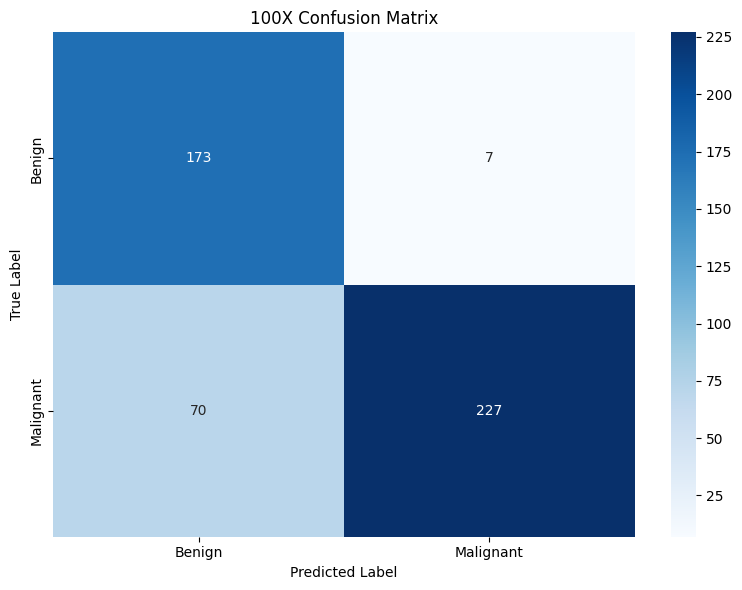


🔬 Training on 200X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   1: Train Loss: 0.1514, Val Loss: 0.1246, Val AUC: 0.8600


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch   2: Train Loss: 0.1352, Val Loss: 0.1089, Val AUC: 0.8593


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch   3: Train Loss: 0.1183, Val Loss: 0.1103, Val AUC: 0.8546


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.11it/s]


Epoch   4: Train Loss: 0.1165, Val Loss: 0.1109, Val AUC: 0.8442


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch   5: Train Loss: 0.1098, Val Loss: 0.1258, Val AUC: 0.8205


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.85it/s]


Epoch   6: Train Loss: 0.1192, Val Loss: 0.1121, Val AUC: 0.8515


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch   7: Train Loss: 0.1133, Val Loss: 0.1033, Val AUC: 0.8788


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.72it/s]


Epoch   8: Train Loss: 0.1229, Val Loss: 0.1169, Val AUC: 0.8378


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch   9: Train Loss: 0.1198, Val Loss: 0.1231, Val AUC: 0.8275


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  10: Train Loss: 0.1228, Val Loss: 0.1220, Val AUC: 0.8437


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  11: Train Loss: 0.1093, Val Loss: 0.1282, Val AUC: 0.8366


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.08it/s]


Epoch  12: Train Loss: 0.1117, Val Loss: 0.1220, Val AUC: 0.8168


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


Epoch  13: Train Loss: 0.1131, Val Loss: 0.1334, Val AUC: 0.8513


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.94it/s]


Epoch  14: Train Loss: 0.1072, Val Loss: 0.1120, Val AUC: 0.8685


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch  15: Train Loss: 0.1106, Val Loss: 0.1162, Val AUC: 0.8498


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  16: Train Loss: 0.1136, Val Loss: 0.1081, Val AUC: 0.8616


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.06it/s]


Epoch  17: Train Loss: 0.1199, Val Loss: 0.1152, Val AUC: 0.8318


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch  18: Train Loss: 0.1124, Val Loss: 0.1101, Val AUC: 0.8540


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  19: Train Loss: 0.1117, Val Loss: 0.1009, Val AUC: 0.8795


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.10it/s]


Epoch  20: Train Loss: 0.1132, Val Loss: 0.1125, Val AUC: 0.8525


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Epoch  21: Train Loss: 0.1019, Val Loss: 0.1138, Val AUC: 0.8549


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  22: Train Loss: 0.1085, Val Loss: 0.1102, Val AUC: 0.8444
⏹️ Early stopping at epoch 22


Testing: 100%|██████████| 14/14 [00:08<00:00,  1.62it/s]



🎯 Best validation AUC: 0.8795
📊Test Metrics for 200X magnification:
  Accuracy: 0.8646
  Precision: 0.9049
  Recall: 0.8718
  Specificity: 0.8529
  F1: 0.8881
  Auc_roc: 0.9209


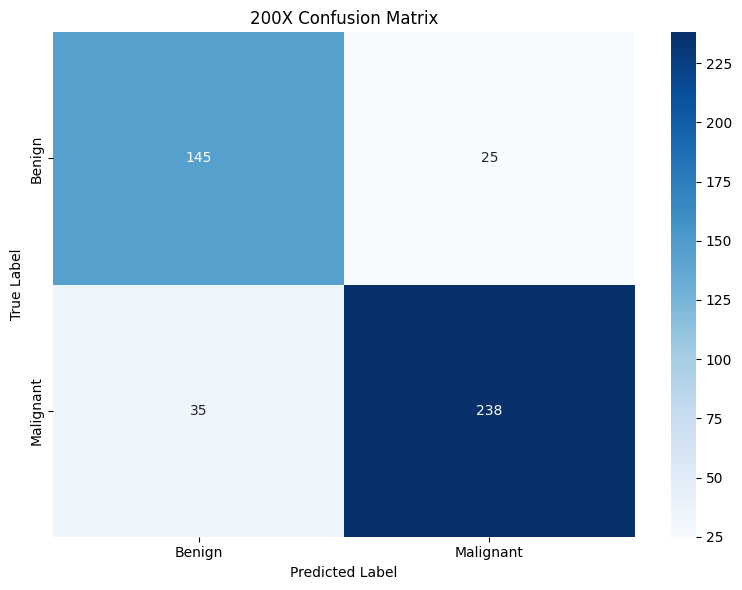


🔬 Training on 400X magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


Epoch   1: Train Loss: 0.1505, Val Loss: 0.1351, Val AUC: 0.8877


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.05it/s]


Epoch   2: Train Loss: 0.1388, Val Loss: 0.1464, Val AUC: 0.8867


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.79it/s]


Epoch   3: Train Loss: 0.1314, Val Loss: 0.1202, Val AUC: 0.8889


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch   4: Train Loss: 0.1243, Val Loss: 0.1040, Val AUC: 0.9131


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch   5: Train Loss: 0.1313, Val Loss: 0.1398, Val AUC: 0.8932


Validation: 100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch   6: Train Loss: 0.1218, Val Loss: 0.1143, Val AUC: 0.8797


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch   7: Train Loss: 0.1229, Val Loss: 0.1360, Val AUC: 0.9058


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch   8: Train Loss: 0.1245, Val Loss: 0.1393, Val AUC: 0.9091


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.96it/s]


Epoch   9: Train Loss: 0.1345, Val Loss: 0.1202, Val AUC: 0.9093


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.12it/s]


Epoch  10: Train Loss: 0.1318, Val Loss: 0.1147, Val AUC: 0.8861


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.78it/s]


Epoch  11: Train Loss: 0.1325, Val Loss: 0.1089, Val AUC: 0.8831


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  12: Train Loss: 0.1196, Val Loss: 0.1075, Val AUC: 0.8770


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.18it/s]


Epoch  13: Train Loss: 0.1257, Val Loss: 0.1241, Val AUC: 0.8203


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.80it/s]


Epoch  14: Train Loss: 0.1358, Val Loss: 0.1287, Val AUC: 0.8653


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.04it/s]


Epoch  15: Train Loss: 0.1315, Val Loss: 0.1150, Val AUC: 0.8523


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.13it/s]


Epoch  16: Train Loss: 0.1118, Val Loss: 0.1271, Val AUC: 0.8978


Validation: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


Epoch  17: Train Loss: 0.1224, Val Loss: 0.1236, Val AUC: 0.8799


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.03it/s]


Epoch  18: Train Loss: 0.1220, Val Loss: 0.1215, Val AUC: 0.8727


Validation: 100%|██████████| 12/12 [00:05<00:00,  2.16it/s]


Epoch  19: Train Loss: 0.1118, Val Loss: 0.1125, Val AUC: 0.8983
⏹️ Early stopping at epoch 19


Testing: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]



🎯 Best validation AUC: 0.9131
📊Test Metrics for 400X magnification:
  Accuracy: 0.8274
  Precision: 0.8541
  Recall: 0.8541
  Specificity: 0.7888
  F1: 0.8541
  Auc_roc: 0.8598


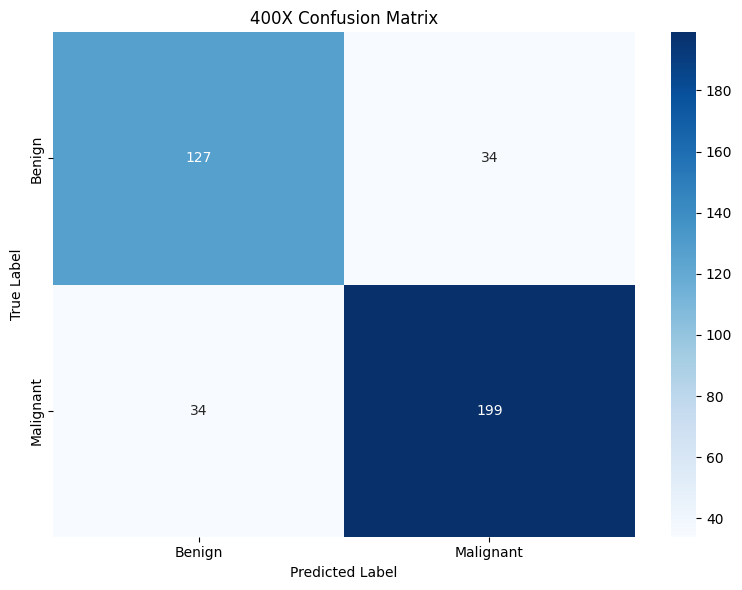


🔬 Training on All magnification
🧬 Using Mixup: True, Focal Loss: True


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   1: Train Loss: 0.1450, Val Loss: 0.1165, Val AUC: 0.8550


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch   2: Train Loss: 0.1347, Val Loss: 0.1223, Val AUC: 0.8583


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.17it/s]


Epoch   3: Train Loss: 0.1286, Val Loss: 0.1243, Val AUC: 0.8459


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch   4: Train Loss: 0.1284, Val Loss: 0.1167, Val AUC: 0.8371


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch   5: Train Loss: 0.1272, Val Loss: 0.1329, Val AUC: 0.8113


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch   6: Train Loss: 0.1252, Val Loss: 0.1048, Val AUC: 0.9051


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch   7: Train Loss: 0.1227, Val Loss: 0.1144, Val AUC: 0.8439


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.08it/s]


Epoch   8: Train Loss: 0.1244, Val Loss: 0.1261, Val AUC: 0.8328


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.18it/s]


Epoch   9: Train Loss: 0.1191, Val Loss: 0.1129, Val AUC: 0.8734


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.16it/s]


Epoch  10: Train Loss: 0.1205, Val Loss: 0.1318, Val AUC: 0.8605


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.09it/s]


Epoch  11: Train Loss: 0.1213, Val Loss: 0.1131, Val AUC: 0.8599


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.06it/s]


Epoch  12: Train Loss: 0.1124, Val Loss: 0.1073, Val AUC: 0.8724


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  13: Train Loss: 0.1229, Val Loss: 0.1200, Val AUC: 0.8662


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.07it/s]


Epoch  14: Train Loss: 0.1125, Val Loss: 0.1175, Val AUC: 0.8695


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.15it/s]


Epoch  15: Train Loss: 0.1184, Val Loss: 0.1018, Val AUC: 0.9031


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Epoch  16: Train Loss: 0.1174, Val Loss: 0.1021, Val AUC: 0.8862


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  17: Train Loss: 0.1201, Val Loss: 0.1082, Val AUC: 0.8970


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.10it/s]


Epoch  18: Train Loss: 0.1162, Val Loss: 0.1109, Val AUC: 0.8763


Validation: 100%|██████████| 48/48 [00:23<00:00,  2.05it/s]


Epoch  19: Train Loss: 0.1198, Val Loss: 0.1211, Val AUC: 0.8731


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.12it/s]


Epoch  20: Train Loss: 0.1160, Val Loss: 0.1093, Val AUC: 0.8811


Validation: 100%|██████████| 48/48 [00:22<00:00,  2.14it/s]


Epoch  21: Train Loss: 0.1185, Val Loss: 0.1138, Val AUC: 0.8872
⏹️ Early stopping at epoch 21


Testing: 100%|██████████| 55/55 [00:29<00:00,  1.89it/s]



🎯 Best validation AUC: 0.9051
📊Test Metrics for All magnification:
  Accuracy: 0.8484
  Precision: 0.9307
  Recall: 0.8098
  Specificity: 0.9076
  F1: 0.8661
  Auc_roc: 0.9075


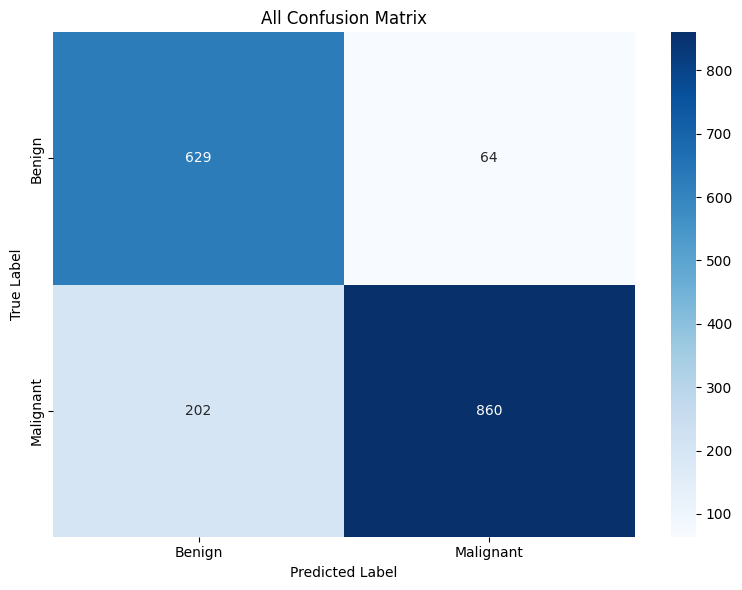


✅ Results saved to 'breakhis_inception_v3_results.csv'

📈 EXPERIMENT SUMMARY - Inception-v3
Average Accuracy: 0.8436
Average AUC-ROC: 0.9047
Best magnification: 200X


In [14]:
if __name__ == "__main__":
    results = main()
